<a href="https://colab.research.google.com/github/meti-94/BERT-QA/blob/main/BuboQA/relations/BuboQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fuzzywuzzy -q
!pip uninstall -y torch -q
!pip install torch==0.4.1 -q
!pip install torchtext==0.2.3 -q

     |████████████████████████████████| 519.5 MB 23 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 0.4.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 0.4.1 which is incompatible.
fastai 1.0.61 requires torch>=1.0.0, but you have torch 0.4.1 which is incompatible.
     |████████████████████████████████| 42 kB 730 kB/s 


In [2]:
!git clone https://github.com/castorini/BuboQA.git
%cd BuboQA

Cloning into 'BuboQA'...
remote: Enumerating objects: 1383, done.
remote: Total 1383 (delta 0), reused 0 (delta 0), pack-reused 1383
Receiving objects: 100% (1383/1383), 361.07 KiB | 3.31 MiB/s, done.
Resolving deltas: 100% (908/908), done.
/content/BuboQA


In [3]:
%cd /content/BuboQA
!bash setup.sh 

/content/BuboQA
Running fetch_dataset script

--2021-10-07 09:26:16--  https://git.uwaterloo.ca/jimmylin/BuboQA-data/raw/master/SimpleQuestions_v2.tgz
Resolving git.uwaterloo.ca (git.uwaterloo.ca)... 129.97.83.4
Connecting to git.uwaterloo.ca (git.uwaterloo.ca)|129.97.83.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 423435590 (404M) [application/x-gzip]
Saving to: ‘SimpleQuestions_v2.tgz’

SimpleQuestions_v2. 100%[===================>] 403.82M  97.8MB/s    in 4.3s    

2021-10-07 09:26:25 (94.9 MB/s) - ‘SimpleQuestions_v2.tgz’ saved [423435590/423435590]



Unzipping SimpleQuestions dataset...

tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
./._SimpleQuestions_v2
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended head

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-10-07 09:42:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-10-07 09:43:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-07 09:43:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [7]:
import pandas as pd
from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from copy import copy
import numpy as np
from sklearn.linear_model import LogisticRegression

In [ ]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train = pd.read_excel('/content/drive/MyDrive/QA/train.xlsx')
valid = pd.read_excel('/content/drive/MyDrive/QA/valid.xlsx')
test = pd.read_excel('/content/drive/MyDrive/QA/test.xlsx')

In [ ]:
def sentence2vector(sentence):
  vectors = []
  for word in sentence.split():
    if word in embeddings_index:
      vectors.append(embeddings_index[word])
    else:
      pass
  vectors = np.array(vectors)
  vector = np.mean(vectors, axis=0)
  return vector

def get_classes_map(dataframe):
  all_normal_rels = [eval(item)[1] for item in dataframe.normalized_triple.to_list()]
  rel2class = {}
  counter = 0
  for item in all_normal_rels:
    if item in rel2class:
      pass
    else:
      rel2class[item]=counter
      counter+=1
  # list(set(all_normal_rels))
  return rel2class
def get_frequent_rels(dataframe, count):
  all_normal_rels = [eval(item)[1] for item in dataframe.normalized_triple.to_list()]
  most_frequent_rels = [word for word, word_count in Counter(all_normal_rels).most_common(count)]
  return most_frequent_rels
def get_features(dataframe, most_frequent_rels):
  onehot_features = []
  for idx, row in tqdm(dataframe.iterrows()):
    temp_rel = eval(row.normalized_triple)[1]
    if temp_rel in most_frequent_rels:
      onehot_features.append(most_frequent_rels.index(temp_rel))
    else:
      onehot_features.append(len(most_frequent_rels))
  label_binarizer = LabelBinarizer()
  label_binarizer.fit(range(max(onehot_features)+1))
  onehot_features = label_binarizer.transform(onehot_features)
  embeddings_features = np.zeros((len(dataframe), 300), )
  for idx, row in tqdm(dataframe.iterrows()):
    vector = sentence2vector(row.Question)
    embeddings_features[idx, :] = vector
  features = np.hstack((embeddings_features, onehot_features))
  return np.nan_to_num(features)
def get_labels(dataframe, classes_map):
  labels = []
  for idx, row in tqdm(dataframe.iterrows()):
    temp_rel = eval(row.normalized_triple)[1]
    if temp_rel in classes_map:
      labels.append(classes_map[temp_rel])
    else:
      labels.append(-1)
  return labels

In [ ]:
most_frequent_rels = get_frequent_rels(train, 300)
class_map = get_classes_map(train)
train_featurs = get_features(train, most_frequent_rels)
train_labels = get_labels(train, class_map)
valid_featurs = get_features(valid, most_frequent_rels)
valid_labels = get_labels(valid, class_map)
test_featurs = get_features(test, most_frequent_rels)
test_labels = get_labels(test, class_map)




9921it [00:01, 8196.55it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
9921it [00:01, 6841.85it/s]
9921it [00:01, 8961.86it/s]
1751it [00:00, 8086.97it/s]
1751it [00:00, 6546.01it/s]
1751it [00:00, 9102.84it/s]
5003it [00:00, 8085.87it/s]
5003it [00:00, 6870.39it/s]
5003it [00:00, 8783.98it/s]


In [ ]:
th = -2
train_mask = np.array(train_labels)>=th
valid_mask = np.array(valid_labels)>=th
test_mask = np.array(test_labels)>=th
tsv_train = copy(train.loc[train_mask, ['Question']])
tsv_valid = copy(valid.loc[valid_mask, ['Question']])
tsv_test = copy(test.loc[test_mask, ['Question']])
tsv_train['rel_label'] = np.array(train_labels)[train_mask].tolist()
tsv_valid['rel_label'] = np.array(valid_labels)[valid_mask].tolist()
tsv_test['rel_label'] = np.array(test_labels)[test_mask].tolist()
tsv_train.to_csv('/content/drive/MyDrive/QA/train.tsv', sep = '\t', index=False)
tsv_valid.to_csv('/content/drive/MyDrive/QA/valid.tsv', sep = '\t', index=False)
tsv_test.to_csv('/content/drive/MyDrive/QA/test.tsv', sep = '\t', index=False)


In [ ]:
len(tsv_test)

5003

In [ ]:
%cd /content/BuboQA/relation_prediction/nn
!python train.py  --fix_embed --relation_prediction_mode GRU \
                  --data_dir /content/drive/MyDrive/QA/ > gru.txt

In [ ]:
clf = LogisticRegression()
# print(valid_featurs.shape, train_featur)
X = np.vstack((train_featurs, valid_featurs)); y = np.array(train_labels+valid_labels)

mask = y >= 0
X = X[mask]; y=y[mask]

clf.fit(X, y)

X_test, y_test = test_featurs, np.array(test_labels)
mask = y_test >= 0
X_test = X_test[mask]; y_test=y_test[mask]


predicted_test = clf.predict(X_test)
accuracy_on_test = 100.0 * np.mean(predicted_test == y_test)
print("Accuracy on Test set: {}".format(accuracy_on_test))

In [14]:
!ls /content/drive/MyDrive/QA/

ls: cannot access '/content/drive/MyDrive/QA/': No such file or directory


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
our_train = pd.read_csv('/content/train.tsv', sep = '\t')
our_valid = pd.read_csv('/content/valid.tsv', sep = '\t')
our_test = pd.read_csv('/content/test.tsv', sep = '\t')
buboqa_train = pd.read_csv('/content/BuboQA/data/processed_simplequestions_dataset/train.txt', sep='\t', header=None)
buboqa_valid = pd.read_csv('/content/BuboQA/data/processed_simplequestions_dataset/valid.txt', sep='\t', header=None)
buboqa_test = pd.read_csv('/content/BuboQA/data/processed_simplequestions_dataset/test.txt', sep='\t', header=None)


buboqa_train_rels = pd.concat([buboqa_train, buboqa_valid])[3].to_list()
buboqa_test_rels = buboqa_test[3].to_list()

print('Our Data Relation Overlap', len([item for item in our_test['rel_label'].to_list() if item!=-1])/len(our_test))
print('Buboqa Data Relation Overlap', len([item for item in buboqa_test_rels if item in buboqa_train_rels])/len(buboqa_test_rels))


columns = ['id', 'sub', 'entity', 'relation', 
           'obj', 'text', 'ed']
our_data = pd.concat([our_train, our_valid, our_test])
buboqa_data = pd.concat([buboqa_train, buboqa_valid, buboqa_test])
buboqa_data.columns = columns
buboqa_data = buboqa_data[['text', 'relation']]
print('Count of Unique rels in our data: {}, buboqa: {}'.format(len(our_data.rel_label.unique()), len(buboqa_data.relation.unique())))

Our Data Relation Overlap 0.8077153707775335
Buboqa Data Relation Overlap 0.9930834140268363
Count of Unique rels in our data: 4234, buboqa: 1836


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f344868ab10>]],
      dtype=object)

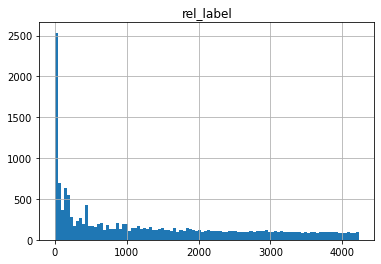

In [12]:
our_data.hist(column=['rel_label'], bins=100)

In [10]:
buboqa_data["relation"] = buboqa_data["relation"].astype('category')
buboqa_data["relation"] = buboqa_data["relation"].cat.codes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3448c975d0>]],
      dtype=object)

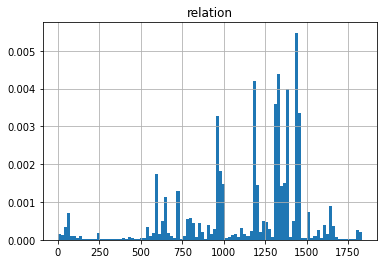

In [11]:
buboqa_data.hist(column=['relation'], bins=100, density=True)

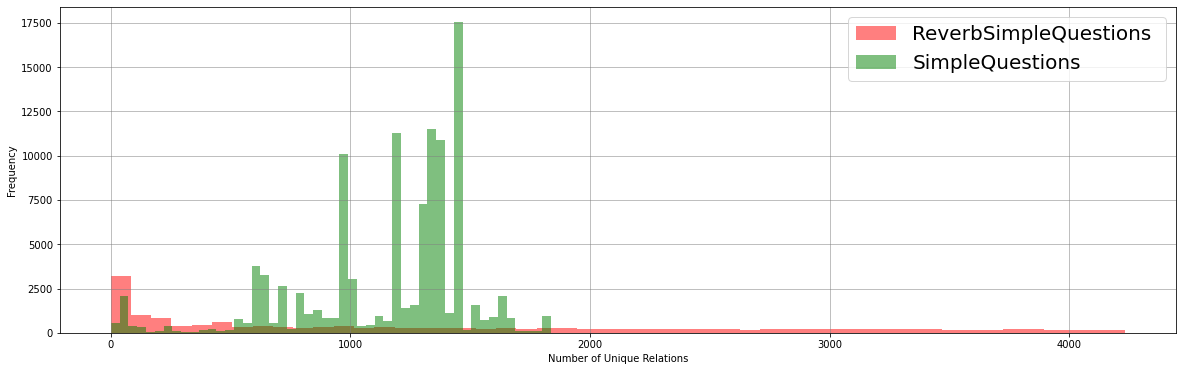

In [33]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.figure(figsize=(20,6))
n, x, _ = plt.hist(our_data['rel_label'], 
         alpha=0.5,
         color='r',
         label='ReverbSimpleQuestions ',
         bins=50)
plt.hist(buboqa_data['relation'],
         alpha=0.5,
         color='g',
         label='SimpleQuestions',
         bins=50)
plt.xlabel("Number of Unique Relations")
plt.ylabel('Frequency')  
plt.legend(loc='upper right', fontsize=20, title_fontsize=15)
plt.grid(color='gray', linestyle='-', linewidth=.5)
# plt.title('Overlapping with alpha=0.1 and 0.9 for sepal and petal')
plt.show()